<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#-Общая-постановка-задачи-" data-toc-modified-id="-Общая-постановка-задачи--1"><span class="toc-item-num">1&nbsp;&nbsp;</span> Общая постановка задачи </a></span></li><li><span><a href="#Метрики-оценки" data-toc-modified-id="Метрики-оценки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Метрики оценки</a></span></li></ul></div>

<h1> Общая постановка задачи </h1>
Курсовая работа по теме «Обогащение таксономии английского языка». Таксономии - это древовидные структуры, которые организуют термины в семантическую иерархию (WordNet). Таксономические отношения (или гиперонимы) являются отношениями «есть-а»: кошка - это животное, банан - это фрукт, Microsoft - это компания и т. Д. Этот тип отношений полезен в широком спектре задач обработки естественного языка для проведение семантического анализа. Цель этой семантической задачи - расширить существующую таксономию отношениями ранее невидимых слов.

Для английского языка и других западноевропейских стран были организованы многочисленные оценочные кампании для извлечения гиперонимов (SemEval-2018, Semeval-2016) и, в первую очередь, для обогащения таксономии (SemEval-2016, задача 14). 

Более конкретно, цель этой задачи заключается в следующем: для слов, которые еще не включены в таксономию, нам нужно связать каждое слово с соответствующими гиперонимами из существующей таксономии. Например, при вводе слова «утка» (утка) мы ожидаем, что вы предоставите список из 10 его наиболее вероятных гиперонимных синсетов, к которым это слово могло бы быть присоединено, например «Животное», «птица» и т. Д. Здесь слово может одновременно относиться к одному, двум или более «предкам» (гипернимальным синсетам).

<h1>Метрики оценки</h1>
В рамках задания ожидаится ранжированного списка из 10 возможных кандидатов для каждого нового слова в тестовом наборе. Оценивать необходимо с использованием <a href="https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision">показателей средней точности (MAP)</a> и <a href="https://ru.qaz.wiki/wiki/Mean_reciprocal_rank">среднего взаимного ранга (MRR)</a>. Оценка MAP обращает внимание на весь диапазон возможных гиперонимов, тогда как MRR смотрит на то, насколько близко к вершине списка находится первое правильное предсказание. В дополнение к этому, оценка F1 будет вычислена для оценки эффективности первого предсказания методов. MAP будет официальной метрикой для ранжирования представленных материалов.

Cчитается правильными ответами не только непосредственные гиперонимы новых слов, но и гиперонимы этих гиперонимов. Следовательно, если система предсказала гипероним или правильный гипероним, это также будет считаться совпадением.

Однако специфика таксономии WordNet и наше предположение о гиперонимах второго порядка могут привести к путанице в процессе оценки. Рассмотрим следующие примеры

Один гипероним может быть «родителем» другого гиперонима (у синсета «Мокша» есть два родительских слова «приток» и «река», тогда как «река» является гиперонимом для «притока»). При подсчете баллов MAP может быть неясно, какая группа гипернимов набирает баллы: группа с синсетом «река» в качестве непосредственного гиперонима или «река» в качестве гиперонима второго порядка.


Гиперонимы могут иметь общих родителей: «струнный инструмент» и «народный инструмент» имеют общие гипернимы «музыкальный инструмент». В этом случае, если в списке кандидатов появится «музыкальный инструмент», MAP также будет запутан. Чтобы избежать этой гиперонимной двусмысленности, мы разделили гиперонимы непосредственного и второго порядка на отдельные группы.

Каждая группа соответствует компоненту связности в подграфе, восстановленном из этих гиперонимов. Мы видим, что первый и второй подграфы обладают только одним компонентом связности по сравнению с последним подграфиком, где непосредственные гиперонимы
образуют разные гипернимые группы.

Следовательно, список возможных кандидатов данного слова должен содержать гиперонимы (хотя бы один) из каждой группы гиперонимов.

In [1]:
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
import networkx as nx
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
from gensim.models import Word2Vec
from nltk.corpus import brown
import numpy as np
import re
import nltk
import tqdm

from gensim.models.wrappers import FastText



from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

Пример генерации графа знаний о словах

In [2]:

def closure_graph(synset,fn):
    seen = set()
    node = set()
    edge = list()  
    def recurse(s):
        if not s in seen:
            seen.add(s)
            print(s.lemma_names('eng')[0])
            node.add(s.lemma_names('eng')[0])
            for s1 in fn(s):
                node.add(s1.lemma_names('eng')[0])
                edge.append((s.lemma_names('eng')[0],s1.lemma_names('eng')[0]))
                recurse(s1)
        return (node,edge)
    return recurse(synset)
# animal = wn.synset('animal.n.01')
dog = wn.synset('dog.n.01')
graph = closure_graph(dog,lambda s: s.hypernyms())
print(graph)

({'carnivore', 'mammal', 'physical_entity', 'entity', 'canine', 'living_thing', 'whole', 'animal', 'chordate', 'domestic_animal', 'dog', 'object', 'organism', 'vertebrate', 'placental'}, [('dog', 'canine'), ('canine', 'carnivore'), ('carnivore', 'placental'), ('placental', 'mammal'), ('mammal', 'vertebrate'), ('vertebrate', 'chordate'), ('chordate', 'animal'), ('animal', 'organism'), ('organism', 'living_thing'), ('living_thing', 'whole'), ('whole', 'object'), ('object', 'physical_entity'), ('physical_entity', 'entity'), ('dog', 'domestic_animal'), ('domestic_animal', 'animal')])


Button(description='Draw', style=ButtonStyle())

Text(value='game', description='String:', placeholder='Query')

graphdraw game


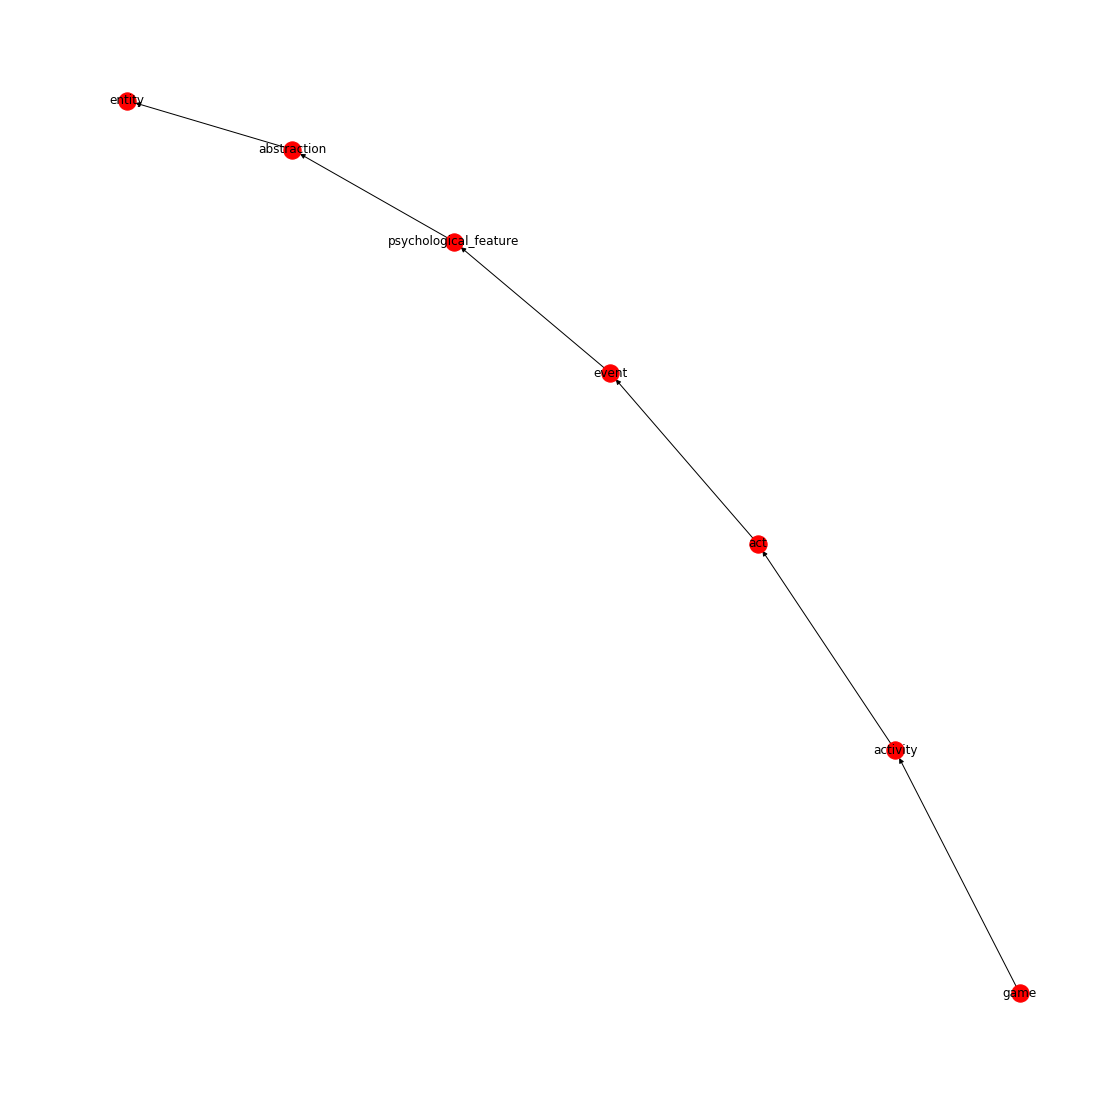

In [3]:
button = widgets.Button(description="Draw")
figure = None
query = widgets.Text(
    value='game',
    placeholder='Query',
    description='String:',
    disabled=False
)
display(button,query)

def graphdraw(b):
    print("graphdraw",query.value)
    global figure
    start = wn.synset(query.value+'.n.01')
    g = nx.DiGraph()
    
    model = closure_graph(start,lambda s: s.hypernyms())
    for el in model[1]:
        g.add_edge(el[0],el[1])
            
    figure = plt.figure(figsize=(15,15))
    pos = nx.nx_agraph.graphviz_layout(g)
    nx.draw(g,with_labels=True,pos=pos)
    plt.axis("off")
    plt.show()
button.on_click(graphdraw)

In [4]:
b = Word2Vec(brown.sents())
# ToDo заменить на FastText

In [5]:
b.most_similar('mother')

/home/ubuntu/.virtualenvs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('father', 0.9693501591682434),
 ('husband', 0.9560144543647766),
 ('wife', 0.941917896270752),
 ('son', 0.908149778842926),
 ('voice', 0.9058479070663452),
 ('brother', 0.8845765590667725),
 ('friend', 0.8748798370361328),
 ('fellow', 0.8704421520233154),
 ('daughter', 0.8688935041427612),
 ('youngster', 0.8597040176391602)]

In [7]:
labels = []
tokens = []

for word in tqdm.tqdm(b.wv.vocab):
    tokens.append(b[word])
    labels.append(word)

  0%|          | 0/15173 [00:00<?, ?it/s]/home/ubuntu/.virtualenvs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
100%|██████████| 15173/15173 [00:00<00:00, 166794.67it/s]


In [10]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

In [13]:
new_values = tsne_model.fit_transform(tokens)

100%|██████████| 15/15 [00:00<00:00, 455.69it/s]


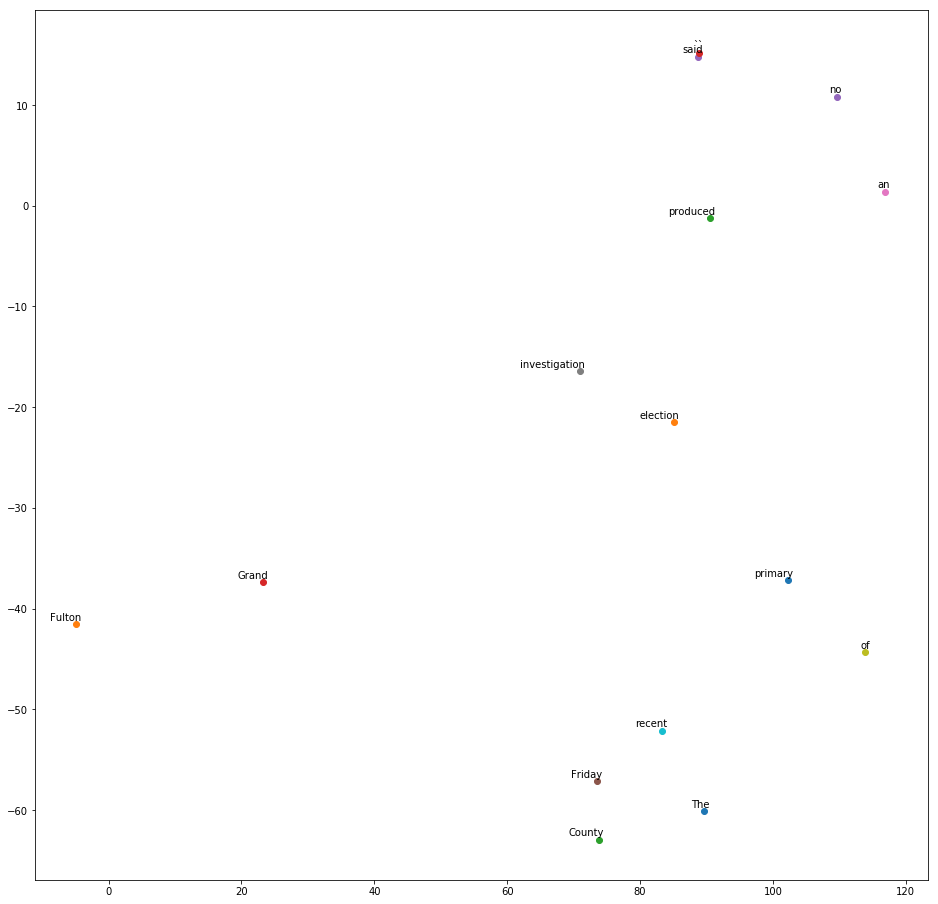

In [14]:
x = []
y = []
for value in tqdm.tqdm(new_values):
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in tqdm.tqdm(range(len(x)//1000)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

Слова для которых нужно найти гиперонимы

In [15]:
import pandas as pd
df = pd.read_excel("./new_words.xlsx",header=None)

In [16]:
df.head()

,0,1
0,A-game,One’s highest level of performance
1,ambigue,An ambiguous statement or expression.
2,Anglosphere,English-speaking countries considered collecti...
3,anti-suffragism,Opposition to the extension of the right to vo...
4,Aperol,A proprietary name for an orange-coloured Ita...


In [17]:
df.tail()

,0,1
94,unfathom,"To come to understand (something mysterious, p..."
95,weak sauce,"That lacks power, substance, or credibility; p..."
96,WFH,An abbreviation for “working from home.”
97,WIP,Work in progress
98,zoodle,"A spiralised strand of zucchini, sometimes use..."
